In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import json
import csv
import time

import tensorflow as tf 
import tensorflow_hub as hub

In [2]:
from wordcloud import WordCloud, STOPWORDS

In [3]:
#!pip install wordcloud

In [4]:
with open('captioning_dataset.json') as json_file:
    data = json.load(json_file)

In [5]:
data['584f1ddf95d0e0392607597e']

{'images': {'1': 'A woman grieved as she waited for the body of her husband to be retrieved from the scene of a multiple homicide at a house in Manila.',
  '0': 'The body of a man killed by unknown gunmen lay behind a convenience store in Manila.',
  '3': 'The funeral of Jimboy Bolasa, 25, who was found killed along with a friend.',
  '2': 'The body of a man killed by unidentified gunmen lay on a street in Mandaluyong, Philippines.'},
 'headline': {'main': 'Rodrigo Duterte Criticizes Times Coverage of Philippine Drug Campaign',
  'print_headline': 'Philippines President Criticizes Times Coverage of Deadly Antidrug Campaign'},
 'abstract': None,
 'article_url': 'https://www.nytimes.com/2016/12/12/world/asia/philippines-president-criticizes-times-piece-on-deadly-antidrug-campaign.html',
 'article': 'His article reported that since the beginning of July, about 2,000 people had been killed by the police and that there had been more than 3,500 unsolved killings in the country. These figures

In [6]:
data['584f1ddf95d0e0392607597e']['article_url']

'https://www.nytimes.com/2016/12/12/world/asia/philippines-president-criticizes-times-piece-on-deadly-antidrug-campaign.html'

In [7]:
min_words = 3
ids, headlines, urls, all_images, articles, lens = [],[],[],[],[],[]

for i, idx in enumerate(data):
    try:
        headline = data[idx]['headline']['main'].strip()
        num_of_words = len(headline.split(' '))
        
        if num_of_words<min_words:
            continue
        
        headlines.append(headline)
        lens.append(num_of_words)
        ids.append(idx)
        urls.append(data[idx]['article_url'])
        all_images.append(data[idx]['images'])
        articles.append(data[idx]['article'])
        
    except:
        pass
    

        

In [8]:
article_df = pd.DataFrame({'id':ids, 'headline':headlines, 'text':articles,'url':urls,'num_words':lens})

In [9]:
article_df.head()

,id,headline,text,url,num_words
0,584f1ddf95d0e0392607597e,Rodrigo Duterte Criticizes Times Coverage of P...,His article reported that since the beginning ...,https://www.nytimes.com/2016/12/12/world/asia/...,9
1,54453eab38f0d832c813e7f5,Facebook Seeps Onto Other Web Sites,The moves by Facebook and its rivals set up a ...,https://www.nytimes.com/2010/04/19/technology/...,6
2,5a57160395d0e0110c1a3f23,A Beginner’s Guide to Backing Up Photos,Both Amazon Prime Photos and Dropbox have thei...,https://www.nytimes.com/2018/01/11/smarter-liv...,7
3,55b40f6b38f0d851b1f6dc7c,Black South Carolina Trooper Explains Why He H...,A different sort of photograph had helped to e...,https://www.nytimes.com/2015/07/26/us/black-so...,11
4,51a92bb440e9ec65d203a9e4,The Right Way to Do the Hillary Step,"KETCHUM, Idaho -- SIXTY years ago this week, a...",https://www.nytimes.com/2013/06/01/opinion/the...,8


In [10]:

img_captions, img_article_ids, caption_lens, nums = [], [], [], []

for i, img in enumerate(all_images):
    for k in img.keys():
        caption = img[k].strip()
        num_words = len(caption.split(' '))
        
        # removing article headlines if the number of words in the headline is less than 5
        if num_words < min_words:
            continue
        
        nums.append(k)
        img_captions.append(caption)
        caption_lens.append(num_words)
        img_article_ids.append(ids[i])
        

In [11]:
# creating a dataframe with our results        
image_df = pd.DataFrame({'article_idx': img_article_ids, 'caption': img_captions, 
                         'num_words': caption_lens, 'number': nums})
print(f'Number of Images: {image_df.shape[0]}')
image_df.head()

Number of Images: 469775


,article_idx,caption,num_words,number
0,584f1ddf95d0e0392607597e,A woman grieved as she waited for the body of ...,27,1
1,584f1ddf95d0e0392607597e,The body of a man killed by unknown gunmen lay...,16,0
2,584f1ddf95d0e0392607597e,"The funeral of Jimboy Bolasa, 25, who was foun...",14,3
3,584f1ddf95d0e0392607597e,The body of a man killed by unidentified gunme...,16,2
4,54453eab38f0d832c813e7f5,Mark Zuckerberg is the chief executive of Face...,8,0


In [12]:
D = 50
glove_data_file = f'glove6B/glove.6B.{D}d.txt'
words = pd.read_csv(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [13]:
words.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.44251,0.187850,0.002785,-0.184110,-0.115140,-0.78581
",",0.013441,0.236820,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.17684,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.18048,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.17792,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044


In [14]:
words_dict = {word: embed for word, embed in zip(words.index, words.values.tolist())}
print(f'Loaded {len(words_dict.keys())} words from the GloVe file')

Loaded 399998 words from the GloVe file


In [15]:
def vec(w, D=50):
    """
    Converts a word to an embedding vector
    """
    try:
        return np.array(words_dict[w])
    # if the word is not in our vocabulary, we return zeros
    except:
        return np.zeros(D)

In [16]:
def average_embedding(sentence, D=50):
    """
    Computes the average embedding of a sentence
    """
    total_embeddings = np.zeros(D)
    num_words = len(sentence.split())
    
    # a sanity check
    if num_words == 0:
        return total_embeddings
    
    # getting the embedding for each word
    for word in sentence.split():
        emb = vec(word)
        total_embeddings += emb
        
    # averaging the embeddings
    avg_embeddings = total_embeddings/num_words
    
    # so that we are not dividing by zero
    if np.linalg.norm(avg_embeddings) > 1e-10:
        return avg_embeddings/np.linalg.norm(avg_embeddings)
    else:
        return avg_embeddings


In [17]:
def preprocessing(sentence):
    """
    Preprocessing. Removes punctuation and stop words
    """
    # removing extra whitespace and making the sentence lower case
    sentence = sentence.lower().strip()
    
    # removing punctuation
    bad_chars = '-.?;,!@#$%^&*()+/{}[]\\":\'“’'
    for char in bad_chars:
        sentence = sentence.replace(char, ' ').strip()
    all_words = sentence.split()
    
    # removing stop words
    filtered_sentence = [w for w in all_words if not w in stopwords]
    return ' '.join(filtered_sentence)

In [18]:
start_time = time.time()
stopwords = set(STOPWORDS)
# saving the embeddings for all the image captions to a numpy array
image_embeddings = np.zeros(shape=(len(image_df), D))
for i, text in enumerate(image_df.caption.values):
    if i % 100000 == 0 and i > 0:
        print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')
    text_prep = preprocessing(text)
    emb = average_embedding(text_prep)
    image_embeddings[i] = average_embedding(text_prep)
print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')

100000 out of 469775 done in 15.48s
200000 out of 469775 done in 30.84s
300000 out of 469775 done in 46.03s
400000 out of 469775 done in 61.16s
469774 out of 469775 done in 71.69s


In [19]:
use_encoder = hub.load("universal-sentence-encoder_4")
print('Loaded USE Model')

2021-10-26 12:10:15.583665: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-26 12:10:15.610154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93b6682f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-26 12:10:15.610167: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Loaded USE Model


In [20]:
use_encoder

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f939a762090>

In [21]:
start_time = time.time()

# saving the use embeddings for all the image captions to a numpy array
use_img_embedding = np.zeros((len(image_df),512))
for i, text in enumerate(image_df.caption.values):
    if i % 100000 == 0 and i > 0:
        print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')
    emb = use_encoder([text])
    use_img_embedding[i] = emb
print(f'{i} out of {len(image_df.caption.values)} done')

# normalize embeddings
use_img_embedding_normalized = use_img_embedding/np.linalg.norm(use_img_embedding,axis=1).reshape(-1,1)

100000 out of 469775 done in 110.42s
200000 out of 469775 done in 222.94s
300000 out of 469775 done in 325.80s
400000 out of 469775 done in 435.60s
469774 out of 469775 done


In [22]:
def predict_glove_images(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # pre-processes the headline
    text_prep = preprocessing(headline)
    
    # finding the average embedding for the headline
    emb = average_embedding(text_prep)
    
    # normalizing the embeddings
    emb = emb.reshape(-1,1)/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(image_embeddings, emb).flatten()
    
    # predict top k images
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

In [23]:
def predict_use_images(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # finding the embedding. No pre-processing is needed
    emb = use_encoder([headline])
    
    # normalizing the embeddings
    emb = emb/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(emb,use_img_embedding.T).flatten()
    
    # predict top k images
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

In [47]:
k = 2
ind = np.random.randint(0, len(article_df)) 
article = article_df.iloc[ind]

article_id = article['id']
headline = article['headline']
url = article['url']
# headline = 'cats and dogs playing'
print(f'Article id: {article_id}, headline: {headline}')
print(f'Url: {url}')

Article id: 575aeb2138f0d82d6b874632, headline: J.F.K. Letter to Lover to Be Auctioned
Url: https://www.nytimes.com/2016/06/11/us/jfk-letter-to-lover-to-be-auctioned.html


USE Predictions


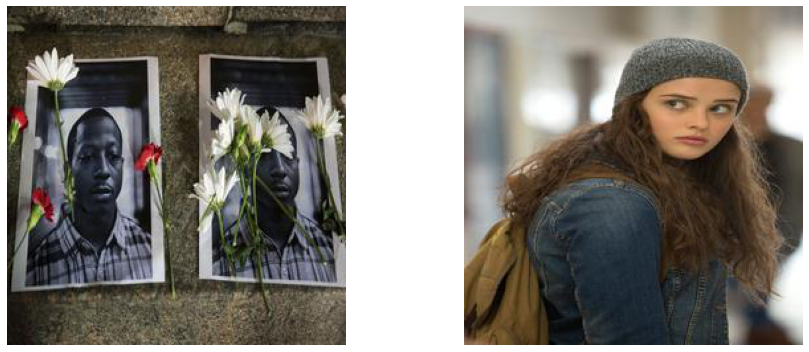

In [56]:
headline = 'Depressed individual commits suicide by hanging himself. Body found in the attic'
results_use = predict_use_images(headline, 3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'resized/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
#     ax[i].set_title(captions[i])
fig.tight_layout()

In [49]:

# results_glove = predict_glove_images(headline, 2)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
# idx = results_glove.article_idx.values
# captions = results_glove.caption.values
# nums = results_glove.number.values
# print(headline)
# print('GloVe Predictions')
# for i in range(k):
#     img = plt.imread(f'resized/{idx[i]}_{nums[i]}.jpg')
#     ax[i].imshow(img)
#     ax[i].set_axis_off()
# #     ax[i].set_title(captions[i])
# fig.tight_layout()